In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet


import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch
import transformers

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
df=pd.read_csv('/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv')
df.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [4]:
df.describe()

review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000

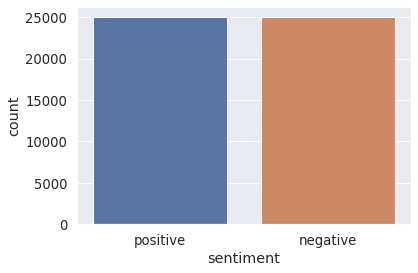

In [5]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(df.sentiment)

In [6]:
df.isna().sum() # Checking for any missing values

review       0
sentiment    0
dtype: int64

In [7]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [8]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

In [9]:
df.sentiment.replace("positive" , 1 , inplace = True)
df.sentiment.replace("negative" , 0 , inplace = True)
df.head()

review  sentiment
0  one reviewers mentioned watching oz episode ex...          1
1  wonderful little filming technique fashion giv...          1
2  thought wonderful way spend time hot summer si...          1
3  basically family little boy thinks zombie clos...          0
4  petter time visually stunning film mattei offe...          1

In [10]:
sns.set(style = "white" , font_scale = 1.2)

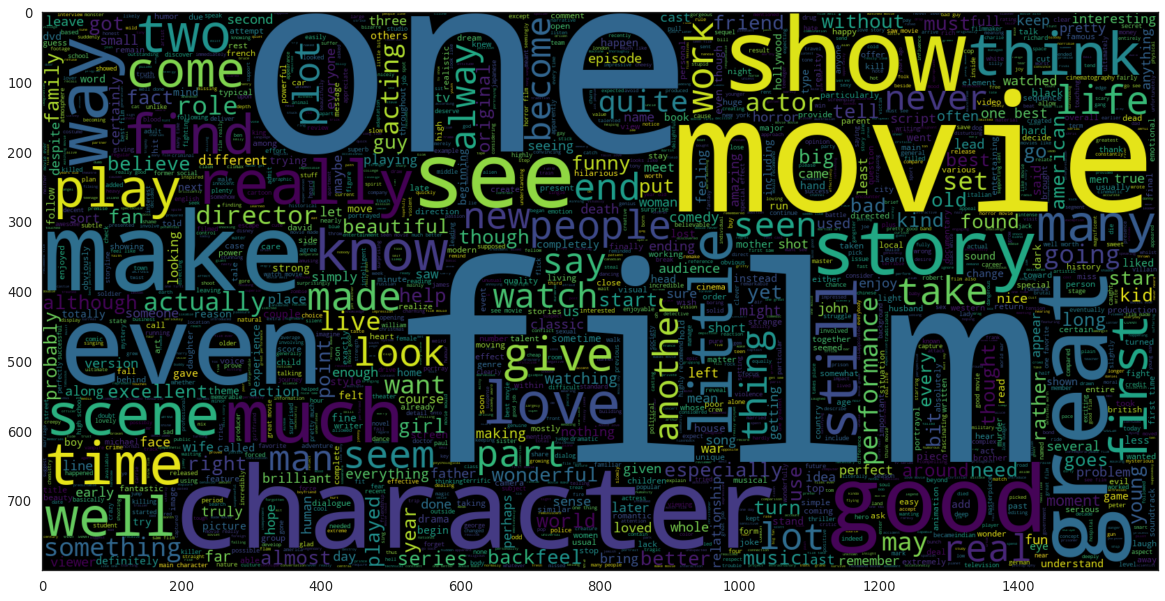

In [11]:
plt.figure(figsize = (20,20)) # Positive Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 1].review))
plt.imshow(wc , interpolation = 'bilinear')

In [12]:
plt.figure(figsize = (20,20)) # Negative Review Text
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.sentiment == 0].review))
plt.imshow(wc , interpolation = 'bilinear')

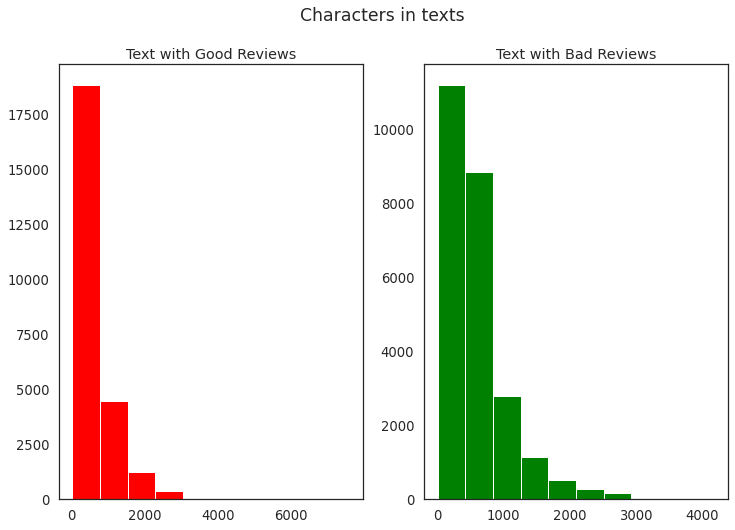

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Characters in texts')
plt.show()

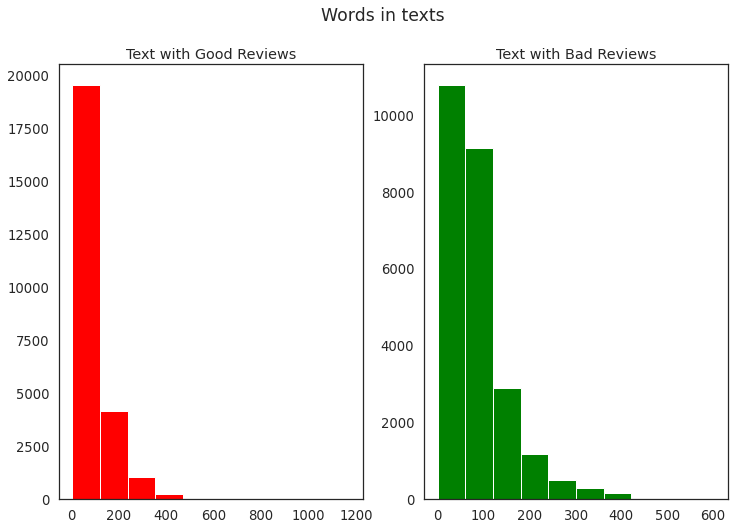

In [14]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=df[df['sentiment']==1]['review'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Text with Good Reviews')
text_len=df[df['sentiment']==0]['review'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Words in texts')
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0.98, 'Average word length in each text')

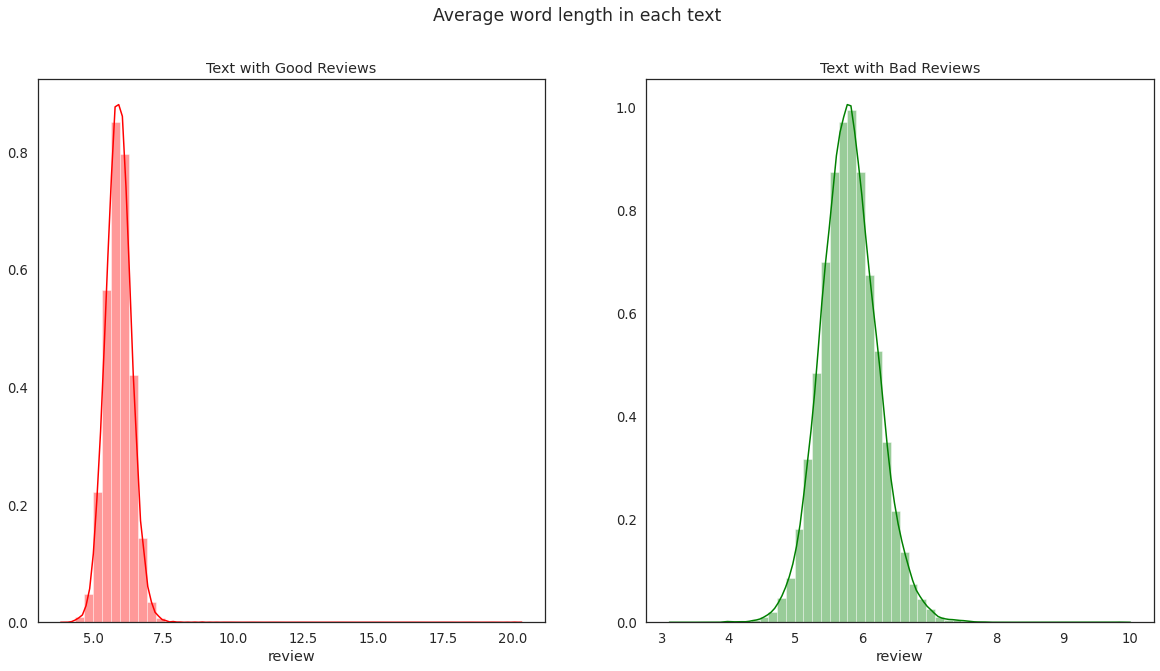

In [15]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['sentiment']==1]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Text with Good Reviews')
word=df[df['sentiment']==0]['review'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Text with Bad Reviews')
fig.suptitle('Average word length in each text')

In [16]:
def get_corpus(text):
    words = []
    for i in text:
        for j in i.split():
            words.append(j.strip())
    return words
corpus = get_corpus(df.review)
corpus[:5]

['one', 'reviewers', 'mentioned', 'watching', 'oz']

In [17]:
from collections import Counter
counter = Counter(corpus)
most_common = counter.most_common(10)
most_common = dict(most_common)
most_common

{'movie': 61496,
 'film': 55088,
 'one': 45067,
 'like': 37303,
 'would': 23815,
 'even': 23720,
 'good': 23475,
 'really': 21806,
 'see': 20906,
 'get': 17692}

In [18]:
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g, g)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [19]:
most_common_uni = get_top_text_ngrams(df.review,20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_uni.keys())
temp["Count"] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Words in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [20]:
most_common_bi = get_top_text_ngrams(df.review,20,2)
most_common_bi = dict(most_common_bi)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_bi.keys())
temp["Count"] = list(most_common_bi.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Bigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [21]:
most_common_tri = get_top_text_ngrams(df.review,20,3)
most_common_tri = dict(most_common_tri)
temp = pd.DataFrame(columns = ["Common_words" , 'Count'])
temp["Common_words"] = list(most_common_tri.keys())
temp["Count"] = list(most_common_tri.values())
fig = px.bar(temp, x="Count", y="Common_words", title='Commmon Trigrams in Text', orientation='h', 
             width=700, height=700,color='Common_words')
fig.show()

In [22]:
x_train,x_test,y_train,y_test = train_test_split(df.review,df.sentiment,random_state = 0 , stratify = df.sentiment)

In [23]:
from tokenizers import BertWordPieceTokenizer
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-uncased' , lower = True)
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=True)
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=True, lowercase=True, wordpieces_prefix=##)

In [24]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=400):

    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in range(0, len(texts), chunk_size):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [25]:
x_train = fast_encode(x_train.values, fast_tokenizer, maxlen=400)
x_test = fast_encode(x_test.values, fast_tokenizer, maxlen=400)

In [26]:
def build_model(transformer, max_len=400):
    
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=2e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [27]:
bert_model = transformers.TFDistilBertModel.from_pretrained('distilbert-base-uncased')

In [28]:
model = build_model(bert_model, max_len=400)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 400)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 400, 768),)       66362880  
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 66,363,649
Trainable params: 66,363,649
Non-trainable params: 0
_________________________________________________________________


In [29]:
history = model.fit(x_train,y_train,batch_size = 32 ,validation_data=(x_test,y_test),epochs = 3)

Epoch 1/3
1172/1172 [==============================] - 1018s 869ms/step - loss: 0.3522 - accuracy: 0.8400 - val_loss: 0.2794 - val_accuracy: 0.8811
Epoch 2/3
1172/1172 [==============================] - 1016s 867ms/step - loss: 0.2379 - accuracy: 0.9033 - val_loss: 0.3428 - val_accuracy: 0.8526
Epoch 3/3
1172/1172 [==============================] - 1015s 866ms/step - loss: 0.1494 - accuracy: 0.9433 - val_loss: 0.3069 - val_accuracy: 0.8855


In [30]:
print("Accuracy of the model on Testing Data is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

391/391 [==============================] - 99s 253ms/step - loss: 0.3069 - accuracy: 0.8855
Accuracy of the model on Testing Data is -  88.55199813842773 %


In [31]:
epochs = [i for i in range(3)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [32]:
pred = model.predict(x_test)
pred[:5]

array([[9.98446286e-01],
       [2.93889083e-04],
       [9.25256219e-03],
       [1.16640195e-01],
       [9.83603597e-01]], dtype=float32)

In [33]:
pred = np.round(pred).astype(int)
pred[:5]

array([[1],
       [0],
       [0],
       [0],
       [1]])

In [34]:
print(classification_report(y_test, pred, target_names = ['Bad Reviews','Good Reviews']))

              precision    recall  f1-score   support

 Bad Reviews       0.91      0.86      0.88      6250
Good Reviews       0.86      0.91      0.89      6250

    accuracy                           0.89     12500
   macro avg       0.89      0.89      0.89     12500
weighted avg       0.89      0.89      0.89     12500



In [35]:
cm = confusion_matrix(y_test,pred)
cm

array([[5353,  897],
       [ 534, 5716]])

In [36]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Bad Reviews','Good Reviews'] , yticklabels = ['Bad Reviews','Good Reviews'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

Text(62.5, 0.5, 'Actual')